# DAQL for BipedalWalker

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('BipedalWalker-v2')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [4]:
# state = env.reset()
# batch = []
# for _ in range(1111):
#     #env.render()
#     action = env.action_space.sample()
#     next_state, reward, done, _ = env.step(action) # take a random action
#     batch.append([state, action, next_state, reward, float(done)])
#     state = next_state
#     if done:
#         state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [5]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [6]:
import numpy as np
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print('states:', np.max(np.array(states)), np.min(np.array(states)))
# print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

In [8]:
# env.action_space.high, env.action_space.low

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [9]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_shape], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.float32, [None, action_size], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_state')
    rewards = tf.placeholder(tf.float32, [None, state_size], name='rewards')
    return states, actions, next_states, rewards

In [10]:
# a = act(s, r)
def generator(states, rewards, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=state_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, rewards])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        pred = tf.tanh(logits)
        return pred

In [11]:
# s', Q = env(s, a)
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        next_states_logits = tf.layers.dense(inputs=nl2, units=state_size)        
        Qlogits = tf.layers.dense(inputs=next_states_logits, units=1, trainable=False)        
        return next_states_logits, Qlogits

In [12]:
def model_loss(action_size, hidden_size, state_size, rewards, states, actions, next_states):
    actions_pred = generator(states=states, rewards=rewards, hidden_size=hidden_size, state_size=state_size)
    _, gQs = discriminator(actions=actions_pred, states=states, hidden_size=hidden_size, action_size=action_size) 
    gloss = -tf.reduce_mean(gQs)
    next_states_pred, _ = discriminator(actions=actions, states=states, hidden_size=hidden_size, 
                                        action_size=action_size, reuse=True) 
    #dloss = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dloss = tf.reduce_mean(tf.reduce_sum(tf.square(next_states - next_states_pred), axis=1)) # DQN
#     print(dloss.shape, tf.square(next_states - next_states_pred).shape)
#     print(dloss.shape, tf.reduce_sum(tf.square(next_states - next_states_pred), axis=1).shape)
    return actions_pred, next_states_pred, gloss, dloss

In [13]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [14]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards = model_input(state_size=state_size, 
                                                                                action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_pred, self.next_states_pred, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, actions=self.actions, next_states=self.next_states, rewards=self.rewards) 
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, 
                                           d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [15]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [16]:
env.observation_space, env.action_space

(Box(24,), Box(4,))

In [17]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size == one episode size is 1000/int(1e3) steps
gamma = 0.99                   # future reward discount

In [18]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [19]:
env.observation_space.high, env.observation_space.low, env.observation_space.shape, \
env.action_space.high, env.action_space.low, env.action_space.shape, \
env.reward_range, env.action_space,

(array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       dtype=float32),
 array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf], dtype=float32),
 (24,),
 array([1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1.], dtype=float32),
 (4,),
 (-inf, inf),
 Box(4,))

In [20]:
# print('states:', np.max(np.array(states)), np.min(np.array(states)))
# print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

In [21]:
# state = env.reset()
# total_reward = 0
# num_step = 0
# for each_step in range(memory_size):
#     action = env.action_space.sample() # randomness
#     action = np.clip(action, -1, 1) # clipped: [-1, +1]
#     next_state, reward, done, _ = env.step(action)
#     rate = -1 # success rate: [-1, +1]
#     memory.buffer.append([state, action, next_state, reward, float(done), rate])
#     num_step += 1 # memory updated
#     total_reward += reward # max reward 300
#     state = next_state
#     if done is True:
#         print('Progress:', each_step/memory_size)
#         state = env.reset()
#         # Best 100-episode average reward was 220.62 ± 0.69. 
#         # (BipedalWalker-v2 is considered "solved" 
#         #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
#         rate = total_reward/300
#         rate = np.clip(rate, -1, 1) 
#         total_reward = 0 # reset
#         for idx in range(num_step): # episode length
#             if memory.buffer[-1-idx][-1] == -1:
#                 memory.buffer[-1-idx][-1] = rate
#         num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
len(memory.buffer), memory.buffer.maxlen

(0, 100000)

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111111111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()
        state_ = np.zeros_like(state)

        # Training steps/batches
        while True:
            env.render()
            action_pred = sess.run(model.actions_pred, feed_dict={model.states: state.reshape([1, -1]),
                                                                  model.rewards: state_.reshape([1, -1])})
            noise = np.random.normal(loc=0, scale=0.1, size=action_size) # randomness
            action = action_pred.reshape([-1]) + noise
            #print(action.shape, action_logits.shape, noise.shape)
            action = np.clip(action, -1, 1) # clipped
            next_state, reward, done, _ = env.step(action)
            #rate = -1 # success rate: -1 to +1
            memory.buffer.append([state, state_, action, next_state])
            #num_step += 1 # memory updated
            total_reward += reward # max reward 300
            state = next_state
            next_state_pred = sess.run(model.next_states_pred, feed_dict={model.states: state.reshape([1, -1]),
                                                                          model.actions: action.reshape([1, -1])})
            state_ = next_state_pred.reshape([-1])
            #print(state.shape, state_.shape, action.shape, next_state.shape)
            #print(state.dtype, state_.dtype, action.dtype, next_state.dtype)
            
            # Training
            if len(memory.buffer) >= batch_size:
                #print('memory readyyyyyyyyyyyyyyyyyyyyy')
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                states_ = np.array([each[1] for each in batch])
                actions = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])
                #print(states.shape, states_.shape, actions.shape, next_states.shape)
                #print(states.dtype, states_.dtype, actions.dtype, next_states.dtype)
                #next_states_logits = sess.run(model.next_states_pred, feed_dict = {model.states: next_states})
                #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # discrete DQN
                #nextQs = nextQs_logits.reshape([-1]) * (1-dones) # continuous DPG
                #targetQs = rewards + (gamma * nextQs)
                gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.next_states: next_states, 
                                                           model.rewards: states_})
                gloss_batch.append(gloss)
                dloss_batch.append(dloss)
                
            if done is True:
                #print(len(memory.buffer))
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        # Did not solve the environment. 
        # Best 100-episode average reward was 220.62 ± 0.69. 
        # (BipedalWalker-v2 is considered "solved" 
        #  when the agent obtains an average reward of at least 300 over 100 consecutive episodes.)        
        if np.mean(episode_reward) >= 300:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode:0 meanR:-104.2189 R:-104.2189 gloss:nan dloss:nan
Episode:1 meanR:-100.7788 R:-97.3386 gloss:0.1648 dloss:7.9181
Episode:2 meanR:-105.1030 R:-113.7515 gloss:0.1819 dloss:6.5080
Episode:3 meanR:-108.7931 R:-119.8633 gloss:0.0597 dloss:5.9579
Episode:4 meanR:-110.4865 R:-117.2601 gloss:-0.0507 dloss:5.5967
Episode:5 meanR:-109.9707 R:-107.3916 gloss:-0.2122 dloss:5.2379
Episode:6 meanR:-111.2779 R:-119.1209 gloss:-0.4614 dloss:4.7171
Episode:7 meanR:-112.3893 R:-120.1692 gloss:-0.6625 dloss:4.2840
Episode:8 meanR:-113.5180 R:-122.5481 gloss:-0.8615 dloss:3.8792
Episode:9 meanR:-114.5333 R:-123.6707 gloss:-1.0473 dloss:3.5472
Episode:10 meanR:-115.3180 R:-123.1648 gloss:-1.2034 dloss:3.2204
Episode:11 meanR:-116.0288 R:-123.8482 gloss:-1.3070 dloss:2.9576
Episode:12 meanR:-116.6078 R:-123.5554 gloss:-1.3798 dloss:2.7167
Episode:13 meanR:-117.0793 R:-123.2090 gloss:-1.4311 dloss:2.5925
Episode:14 meanR:-117.4948 R:-123.3120 gloss:-1.4477 dloss:2.4740
Episode:15 meanR:-117.8626 R:-1

Episode:125 meanR:-122.4781 R:-122.7680 gloss:-1.3744 dloss:0.6333
Episode:126 meanR:-122.4690 R:-122.8009 gloss:-1.3563 dloss:0.6128
Episode:127 meanR:-122.4549 R:-121.8039 gloss:-1.3806 dloss:0.6377
Episode:128 meanR:-122.4462 R:-123.0636 gloss:-1.4036 dloss:0.6202
Episode:129 meanR:-122.4349 R:-122.5569 gloss:-1.3653 dloss:0.6265
Episode:130 meanR:-122.4330 R:-123.3635 gloss:-1.3886 dloss:0.6120
Episode:131 meanR:-122.4254 R:-122.7498 gloss:-1.3692 dloss:0.6226
Episode:132 meanR:-122.4058 R:-121.6450 gloss:-1.3775 dloss:0.6275
Episode:133 meanR:-122.3918 R:-122.0038 gloss:-1.3860 dloss:0.6253
Episode:134 meanR:-122.3740 R:-121.6090 gloss:-1.3818 dloss:0.5985
Episode:135 meanR:-122.3746 R:-123.4402 gloss:-1.3695 dloss:0.6139
Episode:136 meanR:-122.2537 R:-111.5420 gloss:-1.3708 dloss:0.5880
Episode:137 meanR:-122.2521 R:-123.4842 gloss:-1.3838 dloss:0.6002
Episode:138 meanR:-122.2505 R:-123.4922 gloss:-1.3814 dloss:0.5925
Episode:139 meanR:-122.2634 R:-124.5264 gloss:-1.3711 dloss:0.

Episode:248 meanR:-123.1010 R:-122.6611 gloss:-1.3673 dloss:0.4286
Episode:249 meanR:-123.1019 R:-122.8066 gloss:-1.3686 dloss:0.4130
Episode:250 meanR:-123.0942 R:-122.7005 gloss:-1.3639 dloss:0.4047
Episode:251 meanR:-123.0880 R:-122.6032 gloss:-1.3640 dloss:0.4017
Episode:252 meanR:-123.0792 R:-122.3437 gloss:-1.3545 dloss:0.4116
Episode:253 meanR:-123.0811 R:-123.1415 gloss:-1.3664 dloss:0.4265
Episode:254 meanR:-123.0806 R:-122.9821 gloss:-1.3654 dloss:0.4042
Episode:255 meanR:-123.0783 R:-122.7337 gloss:-1.3839 dloss:0.4079
Episode:256 meanR:-123.0975 R:-123.0489 gloss:-1.3637 dloss:0.3932
Episode:257 meanR:-123.1089 R:-123.3312 gloss:-1.3698 dloss:0.4205
Episode:258 meanR:-123.1265 R:-123.2485 gloss:-1.3676 dloss:0.3937
Episode:259 meanR:-123.1254 R:-122.9284 gloss:-1.3786 dloss:0.4046
Episode:260 meanR:-123.1263 R:-122.8213 gloss:-1.3720 dloss:0.4109
Episode:261 meanR:-123.1228 R:-123.3760 gloss:-1.3798 dloss:0.3873
Episode:262 meanR:-123.1182 R:-123.2493 gloss:-1.3626 dloss:0.

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

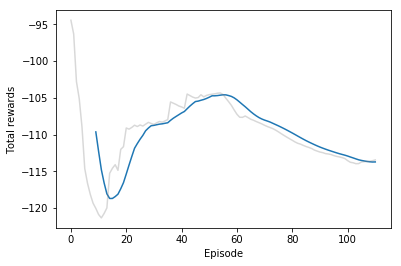

In [44]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

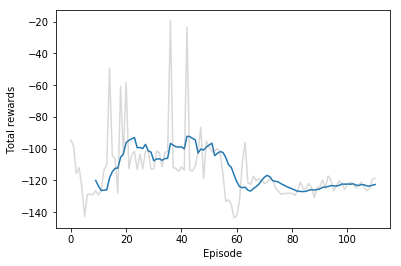

In [45]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'G losses')

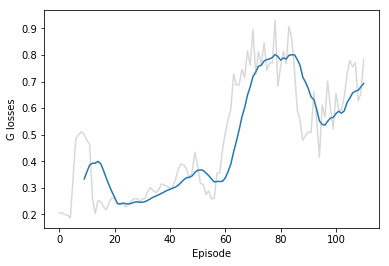

In [46]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0, 0.5, 'D losses')

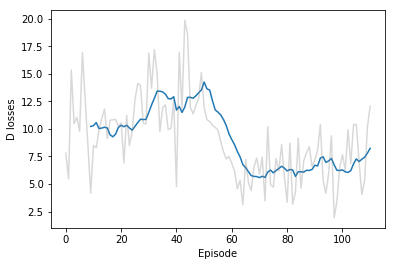

In [47]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [46]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model2.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.reshape(action_logits, [-1]) # For continuous action space
            #action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: -130.50857430583363


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.